# Make Covariance Matrices for Unfolding

In [1]:
# %load_ext autoreload
# %autoreload 2

# #print all output
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib as mpl
from os import path
import sys
import uproot
from tqdm import tqdm

# local imports
sys.path.append('/exp/sbnd/app/users/munjung/xsec/cafpyana')
from analysis_village.numucc1p0pi.variable_configs import *
from analysis_village.unfolding.wienersvd import *
from analysis_village.unfolding.unfolding_inputs import *
from analysis_village.numucc1p0pi.selection_definitions import *
from pyanalib.split_df_helpers import *
from makedf.geniesyst import regen_systematics_sbnd_multisigma, regen_systematics_sbnd_morph
from makedf.constants import *

plt.style.use("presentation.mplstyle")
cmap = mpl.cm.viridis
norm = mpl.colors.Normalize(vmin=0.0, vmax=1.0)
import matplotlib
import seaborn as sns
# plt.style.use('seaborn-v0_8-colorblind')
matplotlib.rcParams['axes.prop_cycle'] = matplotlib.cycler(color=plt.get_cmap('Set2').colors)


# filter Performance warning
import warnings
from pandas.errors import PerformanceWarning
warnings.filterwarnings("ignore", category=PerformanceWarning)

In [3]:
save_fig = True
save_fig_dir = "/exp/sbnd/data/users/munjung/plots/numucc1p0pi/systs"

# load dataframes

In [4]:
file_dir = "/exp/sbnd/data/users/munjung/xsec/2025B"

## -- MC 
# selected
mc_file = path.join(file_dir, "MC_bnb_cosmics-fullsel-wgts_all.df")
# mc_file = path.join(file_dir, "MC_bnb_cosmics-fullsel-wgts_zexp_all.df")
mc_split_df = pd.read_hdf(mc_file, key="split")
mc_n_split = get_n_split(mc_file)
print("mc_n_split: %d" %(mc_n_split))
print_keys(mc_file)

# all simulated nus w/ genie weights -- for xsec systs
mcallnu_file = path.join(file_dir, "MC_bnb_cosmics-mcnu-geniewgts_multisim.df")
# mcallnu_file = path.join(file_dir, "MC_bnb_cosmics-mcnu-geniewgts_zexp.df")
mcallnu_split_df = pd.read_hdf(mcallnu_file, key="split")
mcallnu_n_split = get_n_split(mcallnu_file)
print("mcallnu_n_split: %d" %(mcallnu_n_split))
print_keys(mcallnu_file)

mc_n_split: 10
Keys: ['/evt_0', '/evt_1', '/evt_2', '/evt_3', '/evt_4', '/evt_5', '/evt_6', '/evt_7', '/evt_8', '/evt_9', '/hdr_0', '/hdr_1', '/hdr_2', '/hdr_3', '/hdr_4', '/hdr_5', '/hdr_6', '/hdr_7', '/hdr_8', '/hdr_9', '/split']
mcallnu_n_split: 140
Keys: ['/hdr_0', '/hdr_1', '/hdr_10', '/hdr_100', '/hdr_101', '/hdr_102', '/hdr_103', '/hdr_104', '/hdr_105', '/hdr_106', '/hdr_107', '/hdr_108', '/hdr_109', '/hdr_11', '/hdr_110', '/hdr_111', '/hdr_112', '/hdr_113', '/hdr_114', '/hdr_115', '/hdr_116', '/hdr_117', '/hdr_118', '/hdr_119', '/hdr_12', '/hdr_120', '/hdr_121', '/hdr_122', '/hdr_123', '/hdr_124', '/hdr_125', '/hdr_126', '/hdr_127', '/hdr_128', '/hdr_129', '/hdr_13', '/hdr_130', '/hdr_131', '/hdr_132', '/hdr_133', '/hdr_134', '/hdr_135', '/hdr_136', '/hdr_137', '/hdr_138', '/hdr_139', '/hdr_14', '/hdr_15', '/hdr_16', '/hdr_17', '/hdr_18', '/hdr_19', '/hdr_2', '/hdr_20', '/hdr_21', '/hdr_22', '/hdr_23', '/hdr_24', '/hdr_25', '/hdr_26', '/hdr_27', '/hdr_28', '/hdr_29', '/hdr_3', 

In [19]:
# concat dfs 
n_max_concat = 2
mc_keys2load = ['hdr', 'evt']
mc_dfs = load_dfs(mc_file, mc_keys2load, n_max_concat=n_max_concat)
mc_hdr_df = mc_dfs['hdr']
mc_evt_df = mc_dfs['evt']

n_max_concat = 10
mcallnu_keys2load = ['mcnuwgt', 'hdr']
mcallnu_dfs = load_dfs(mcallnu_file, mcallnu_keys2load, n_max_concat=n_max_concat)
mcallnu_wgt_df = mcallnu_dfs['mcnuwgt']
mcallnu_hdr_df = mcallnu_dfs['hdr']

In [20]:
regen_systematics_sbnd_multisim = [
    "GENIEReWeight_SBN_v1_multisim_ZExpAVariationResponse",
    "GENIEReWeight_SBN_v1_multisim_NCELVariationResponse",
    'GENIEReWeight_SBN_v1_multisim_RPA_CCQE',
    'GENIEReWeight_SBN_v1_multisim_CoulombCCQE',
    'GENIEReWeight_SBN_v1_multisim_NormCCMEC',
    'GENIEReWeight_SBN_v1_multisim_NormNCMEC',
    'GENIEReWeight_SBN_v1_multisim_CCRESVariationResponse',
    'GENIEReWeight_SBN_v1_multisim_NCRESVariationResponse',
    'GENIEReWeight_SBN_v1_multisim_NonRESBGvpCC1pi',
    'GENIEReWeight_SBN_v1_multisim_NonRESBGvpCC2pi',
    'GENIEReWeight_SBN_v1_multisim_NonRESBGvpNC1pi',
    'GENIEReWeight_SBN_v1_multisim_NonRESBGvpNC2pi',
    'GENIEReWeight_SBN_v1_multisim_NonRESBGvnCC1pi',
    'GENIEReWeight_SBN_v1_multisim_NonRESBGvnCC2pi',
    'GENIEReWeight_SBN_v1_multisim_NonRESBGvnNC1pi',
    'GENIEReWeight_SBN_v1_multisim_NonRESBGvnNC2pi',
    'GENIEReWeight_SBN_v1_multisim_NonRESBGvbarpCC1pi',
    'GENIEReWeight_SBN_v1_multisim_NonRESBGvbarpCC2pi',
    'GENIEReWeight_SBN_v1_multisim_NonRESBGvbarpNC1pi',
    'GENIEReWeight_SBN_v1_multisim_NonRESBGvbarpNC2pi',
    'GENIEReWeight_SBN_v1_multisim_NonRESBGvbarnCC1pi',
    'GENIEReWeight_SBN_v1_multisim_NonRESBGvbarnCC2pi',
    'GENIEReWeight_SBN_v1_multisim_NonRESBGvbarnNC1pi',
    'GENIEReWeight_SBN_v1_multisim_NonRESBGvbarnNC2pi',
    'GENIEReWeight_SBN_v1_multisim_RDecBR1gamma',
    'GENIEReWeight_SBN_v1_multisim_RDecBR1eta',
    'GENIEReWeight_SBN_v1_multisim_COHVariationResponse',
    'GENIEReWeight_SBN_v1_multisim_DISBYVariationResponse',
    'GENIEReWeight_SBN_v1_multisim_FSI_pi_VariationResponse',
    'GENIEReWeight_SBN_v1_multisim_FSI_N_VariationResponse',
]

# Additional FV cut
TODO: match this in df making

In [21]:
mc_evt_df = mc_evt_df[InFV(mc_evt_df.slc.vertex)]

# Calculate additional variables

In [22]:
# the df will all nus don't have TKI variables pre-calculated
# calculate them here
from pyanalib.variable_calculator import get_cc1p0pi_tki
from pyanalib.pandas_helpers import pad_column_name

P_mu_col = pad_column_name(("totp",), mcallnu_wgt_df.mu)
P_p_col = pad_column_name(("totp",), mcallnu_wgt_df.p)
ret_tki = get_cc1p0pi_tki(mcallnu_wgt_df.mu, mcallnu_wgt_df.p, P_mu_col, P_p_col)
mcallnu_wgt_df["del_Tp"] = ret_tki["del_Tp"]
mcallnu_wgt_df["del_Tp_x"] = ret_tki["del_Tp_x"]
mcallnu_wgt_df["del_Tp_y"] = ret_tki["del_Tp_y"]
mcallnu_wgt_df["del_p"] = ret_tki["del_p"]
mcallnu_wgt_df["del_alpha"] = ret_tki["del_alpha"]
mcallnu_wgt_df["del_phi"] = ret_tki["del_phi"]

# the angles from old dfs are in rad -- convert to deg
mc_evt_df["del_alpha"] *= (180/np.pi)
mc_evt_df["del_phi"] *= (180/np.pi)
mc_evt_df["mc_del_alpha"] *= (180/np.pi)
mc_evt_df["mc_del_phi"] *= (180/np.pi)

/exp/sbnd/app/users/munjung/xsec/cafpyana/envs/venv_py39_cafpyana/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_175951/2731655649.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mc_evt_df["del_alpha"] *= (180/np.pi)
/tmp/ipykernel_175951/2731655649.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mc_evt_df["del_phi"] *= (180/np.pi)
/tmp/ipykernel_175951/2731655649.py:1

In [23]:
print(np.max(mc_evt_df["del_alpha"]))
print(np.max(mc_evt_df["del_phi"]))
print(np.max(mc_evt_df["mc_del_alpha"]))
print(np.max(mc_evt_df["mc_del_phi"]))
print(np.max(mcallnu_wgt_df["del_alpha"]))
print(np.max(mcallnu_wgt_df["del_phi"]))

179.99131540896437
179.95131605805014
180.0
179.7618
180.0
180.0


# Calculate Systs

# POT

In [24]:
## total pot
mc_tot_pot = mc_hdr_df['pot'].sum()
print("mc_tot_pot: %.3e" %(mc_tot_pot))

mcallnu_tot_pot = mcallnu_hdr_df['pot'].sum()
print("mcallnu_tot_pot: %.3e" %(mcallnu_tot_pot))

# target_pot = 1e20
target_pot = mc_tot_pot
mc_pot_scale = target_pot / mc_tot_pot
print("mc_pot_scale: %.3e" %(mc_pot_scale))

mcallnu_pot_scale = target_pot / mcallnu_tot_pot
print("mcallnu_pot_scale: %.3e" %(mcallnu_pot_scale))
mc_evt_df["pot_weight"] = mc_pot_scale * np.ones(len(mc_evt_df))

mc_tot_pot: 1.291e+20
mcallnu_tot_pot: 4.318e+19
mc_pot_scale: 1.000e+00
mcallnu_pot_scale: 2.990e+00


/tmp/ipykernel_175951/2032503521.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mc_evt_df["pot_weight"] = mc_pot_scale * np.ones(len(mc_evt_df))


# Constants

['flux_sbnd_numu;1', 'flux_sbnd_nue;1', 'flux_sbnd_anumu;1', 'flux_sbnd_anue;1']


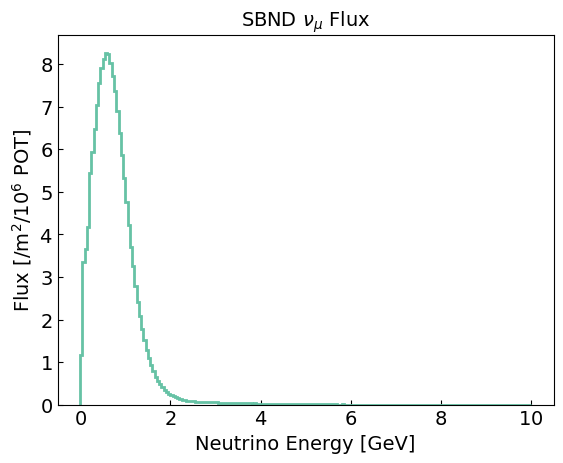

Integrated flux: 2.085e+12


In [25]:
# TODO: z-dependence?
# flux file, units: /m^2/10^6 POT 
# 50 MeV bins
fluxfile = "/exp/sbnd/data/users/munjung/flux/sbnd_original_flux.root"
flux = uproot.open(fluxfile)
print(flux.keys())

# numu flux
numu_flux = flux["flux_sbnd_numu"].to_numpy()
bin_edges = numu_flux[1]
flux_vals = numu_flux[0]

plt.hist(bin_edges[:-1], bins=bin_edges, weights=flux_vals, histtype="step", linewidth=2)
plt.xlabel("Neutrino Energy [GeV]")
plt.ylabel("Flux [/m$^{2}$/10$^{6}$ POT]")
plt.title("SBND $\\nu_\\mu$ Flux")

# if save_fig:
#     plt.savefig("{}/sbnd-flux.pdf".format(save_fig_dir))
plt.savefig("sbnd-flux.pdf", bbox_inches='tight')
plt.show()

# get integrated flux
integrated_flux = flux_vals.sum()
integrated_flux /= 1e4 # to cm2
INTEGRATED_FLUX = integrated_flux * mc_tot_pot / 1e6 # POT
print("Integrated flux: %.3e" % INTEGRATED_FLUX)

In [26]:
V_SBND = 380 * 380 * 440 # cm3, the active volume of the detector 
NTARGETS = RHO * V_SBND * N_A / M_AR
print("# of targets: ", NTARGETS)

# of targets:  1.3251484770937053e+30


In [27]:
# set to 1 for event rates
XSEC_UNIT = 1 / (INTEGRATED_FLUX * NTARGETS)
print("xsec unit: ", XSEC_UNIT)

xsec unit:  3.6192046135874454e-43


# Set up utils and selections according to target channel

# Choose Variable to Unfold

In [28]:
# frac_cov_matrices = {}

In [64]:
# choose a variable to unfold, defined in variable_configs.py
var_config = VariableConfig.muon_momentum()
# var_config = VariableConfig.muon_direction()
# var_config = VariableConfig.proton_momentum()
# var_config = VariableConfig.proton_direction()
# var_config = VariableConfig.tki_del_Tp()
# var_config.var_nu_col = ('mc_del_Tp', '', '')
# var_config = VariableConfig.tki_del_Tp_x()
# var_config = VariableConfig.tki_del_Tp_y()
# var_config = VariableConfig.tki_del_alpha()
# var_config.var_nu_col = ('mc_del_alpha', '', '')
# var_config = VariableConfig.tki_del_phi()
# var_config.var_nu_col = ('mc_del_phi', '', '')

# single bin
# var_config.bins = [np.min(var_config.bins), np.max(var_config.bins)]
# var_config.bin_centers = [np.mean(var_config.bins)]
# save_fig = False

var_name = "_".join([v for v in var_config.var_nu_col if len(v) > 0])
frac_cov_matrices[var_name] = {}

# Make dfs for analysis

np.clip is for including underflow events into the first bin and overflow events into the last bin

In [30]:
print("==== selected events ====")
mc_evt_df.loc[:,'nuint_categ'] = get_int_category(mc_evt_df)
mc_evt_df.loc[:,'genie_categ'] = get_genie_category(mc_evt_df)
print(mc_evt_df.nuint_categ.value_counts())
print(mc_evt_df.genie_categ.value_counts())

print("==== all events ====")
mcallnu_wgt_df.loc[:,'nuint_categ'] = get_int_category(mcallnu_wgt_df)
mcallnu_wgt_df.loc[:,'genie_categ'] = get_genie_category(mcallnu_wgt_df)
print(mcallnu_wgt_df.nuint_categ.value_counts())
print(mcallnu_wgt_df.genie_categ.value_counts())


==== selected events ====


/tmp/ipykernel_175951/3000421475.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mc_evt_df.loc[:,'nuint_categ'] = get_int_category(mc_evt_df)
/tmp/ipykernel_175951/3000421475.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mc_evt_df.loc[:,'genie_categ'] = get_genie_category(mc_evt_df)


nuint_categ
 1    20270
 3      648
 2      622
 4      338
-1      128
 0       33
 5       29
Name: count, dtype: int64
genie_categ
 1    17986
 2     2651
 3      867
 6      338
-1      128
 4       35
 0       33
 7       29
 5        1
Name: count, dtype: int64
==== all events ====
nuint_categ
0    639894
3     95532
4     68923
1     54651
2     24208
5      4058
Name: count, dtype: int64
genie_categ
0    639894
1     92189
6     68923
3     49177
2     23489
4      9228
7      4058
5       308
Name: count, dtype: int64


In [31]:
# Total MC reco muon momentum: for fake data
eps = 1e-8
var_total_mc = mc_evt_df[var_config.var_evt_reco_col]
var_total_mc = np.clip(var_total_mc, var_config.bins[0], var_config.bins[-1] - eps)
weights_total_mc = mc_evt_df.loc[:, 'pot_weight']

# --- all events, selected ---
# mc_evt_df divided into topology modes for subtraction from data in future
# first item in list is the signal topology
mc_evt_df_divided = [mc_evt_df[mc_evt_df.nuint_categ == mode]for mode in topology_list]

# Reco variable distribution for each 'nuint_categ' for stack plot and subtraction from the fake data
var_per_nuint_categ_mc = [mc_evt_df[mc_evt_df.nuint_categ == mode][var_config.var_evt_reco_col]for mode in topology_list]
var_per_nuint_categ_mc = [s.clip(var_config.bins[0], var_config.bins[-1] - eps) for s in var_per_nuint_categ_mc]
weights_per_categ = [mc_evt_df.loc[mc_evt_df.nuint_categ == mode, 'pot_weight'] for mode in topology_list]

# Reco variable distribution for each genie mode
var_per_genie_mode_mc = [mc_evt_df[mc_evt_df.genie_categ == mode][var_config.var_evt_reco_col]for mode in genie_mode_list]
var_per_genie_mode_mc = [s.clip(var_config.bins[0], var_config.bins[-1] - eps) for s in var_per_genie_mode_mc]
weights_per_genie_mode = [mc_evt_df.loc[mc_evt_df.genie_categ == mode, 'pot_weight'] for mode in genie_mode_list]


# --- signal events ---
# selected, for response matrix
# Signal event's reco muon momentum after the event selection
var_signal_sel_reco = mc_evt_df[mc_evt_df.nuint_categ == 1][var_config.var_evt_reco_col]
var_signal_sel_reco = np.clip(var_signal_sel_reco, var_config.bins[0], var_config.bins[-1] - eps)
weight_signal = mc_evt_df.loc[mc_evt_df.nuint_categ == 1, 'pot_weight']

# Signal event's true muon momentum after the event selection
var_signal_sel_truth = mc_evt_df[mc_evt_df.nuint_categ == 1][var_config.var_evt_truth_col]
var_signal_sel_truth = np.clip(var_signal_sel_truth, var_config.bins[0], var_config.bins[-1] - eps)
weight_true_signal = mc_evt_df.loc[mc_evt_df.nuint_categ == 1, 'pot_weight']

# total generated, for efficiency vector
# Signal event's true muon momentum without event selection
var_truth_signal = mcallnu_wgt_df[mcallnu_wgt_df.nuint_categ == 1][var_config.var_nu_col]
var_truth_signal = np.clip(var_truth_signal, var_config.bins[0], var_config.bins[-1] - eps)
weight_truth_signal = np.full_like(var_truth_signal, mc_pot_scale, dtype=float)

# Response Matrix

Draw true (before event selection) and reco (after event selection) muon momentum distributions of signal events.
Print entries for double check.

[4267. 4964. 5125. 5005. 4608. 4517. 4115. 3780. 3500. 3022. 2799. 2445.
 3684. 2820.]
[1973. 2715. 2653. 2326. 2099. 1784. 1508. 1315. 1066.  823.  651.  511.
  543.  303.]
[2050. 2673. 2632. 2349. 2061. 1763. 1547. 1270. 1067.  827.  683.  484.
  576.  288.]


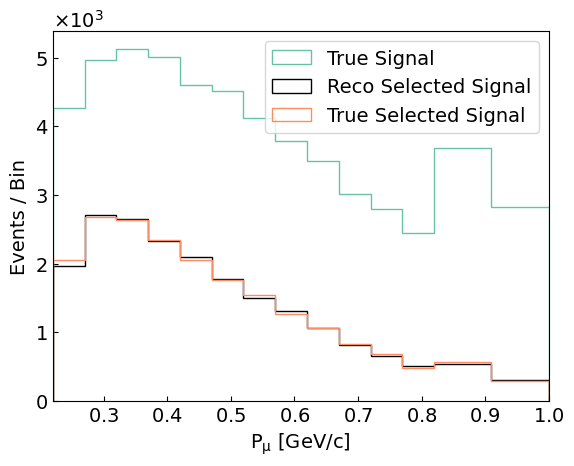

In [32]:
nevts_signal_truth, _, _ = plt.hist(var_truth_signal, bins=var_config.bins, weights=weight_truth_signal, histtype="step", label="True Signal")
nevts_signal_sel_reco, _, _ = plt.hist(var_signal_sel_reco, bins=var_config.bins, weights=weight_signal, histtype="step", label="Reco Selected Signal", color="k")
nevts_signal_sel_truth, _, _ = plt.hist(var_signal_sel_truth, bins=var_config.bins, weights=weight_signal, histtype="step", label="True Selected Signal")
print(nevts_signal_truth)
print(nevts_signal_sel_reco)
print(nevts_signal_sel_truth)
plt.legend()
plt.ylabel("Events / Bin")
plt.xlim(var_config.bins[0], var_config.bins[-1])
plt.xlabel(var_config.var_labels[0])
if save_fig:
    plt.savefig("{}/{}-sel_event_rates.pdf".format(save_fig_dir, var_config.var_save_name), bbox_inches='tight')
plt.show()

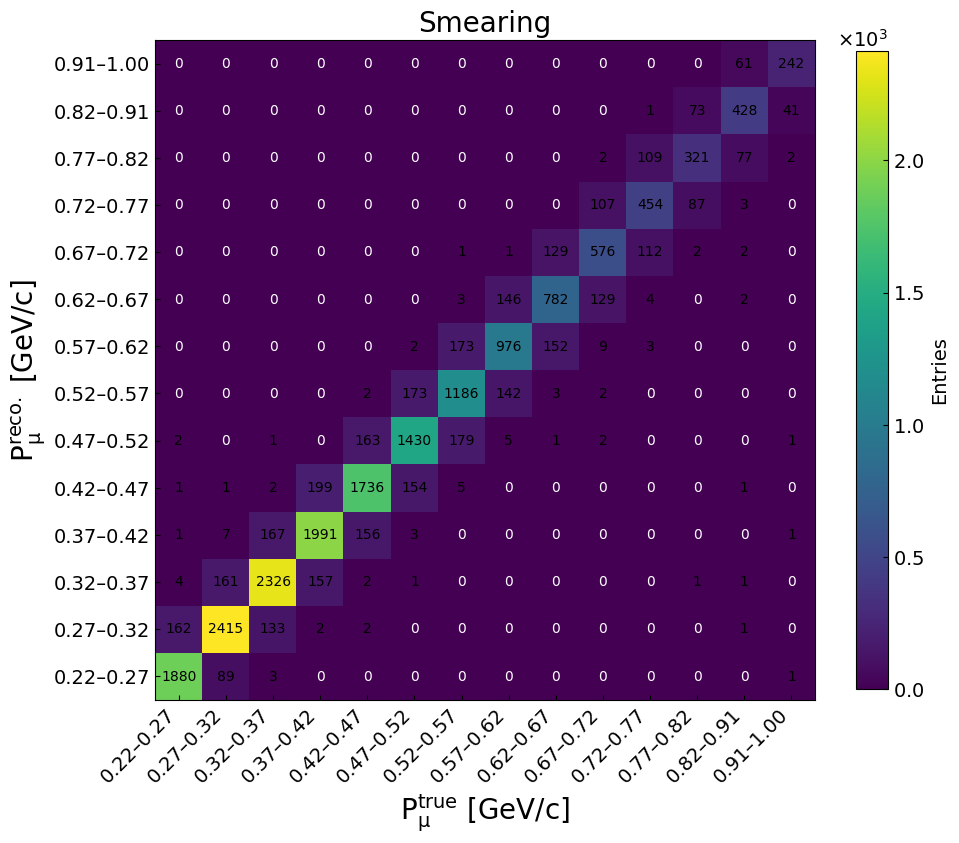

eff


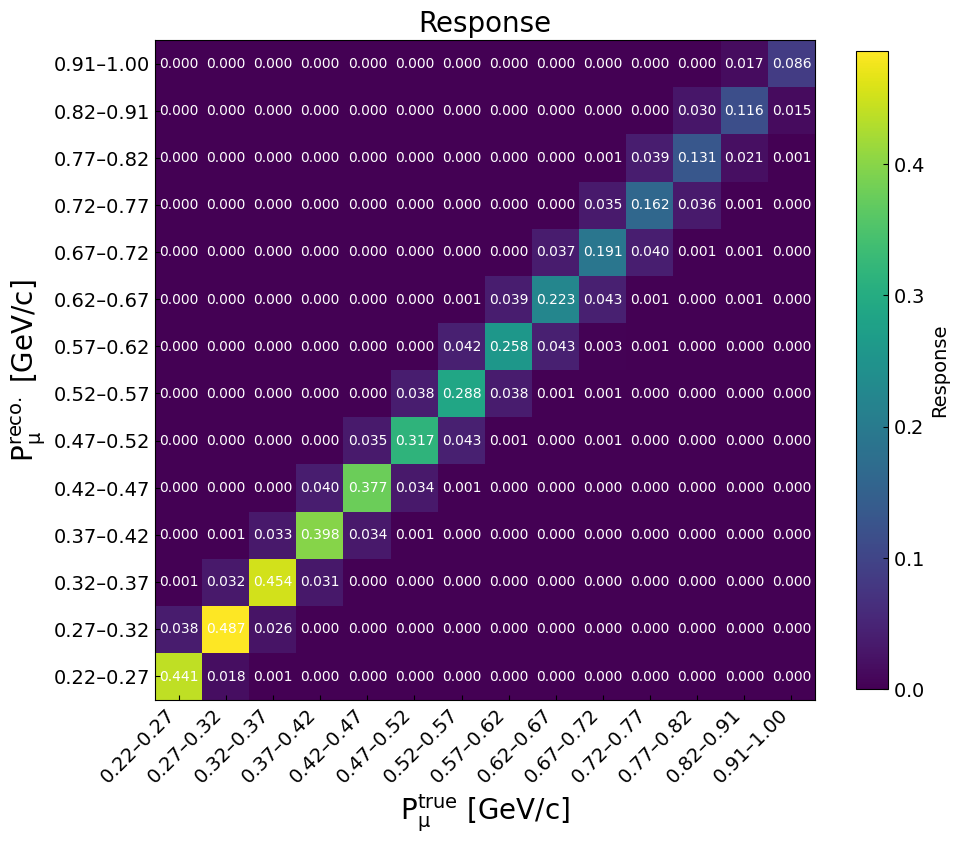

In [33]:
bins_2d = [var_config.bins, var_config.bins]# = [np.array([0.2, 2]), np.array([0.2, 2])] # commented out lines for 1 bin MC closure test

save_fig_name = "{}/{}-reco_vs_true".format(save_fig_dir, var_config.var_save_name)
reco_vs_true = get_smear_matrix(var_signal_sel_truth, var_signal_sel_reco, bins_2d, var_labels=var_config.var_labels,
                                save_fig=save_fig, save_fig_name=save_fig_name)
eff = get_eff(reco_vs_true, nevts_signal_truth)
print("eff")
# print(eff)

save_fig_name = "{}/{}-response_matrix".format(save_fig_dir, var_config.var_save_name)
Response = get_response_matrix(reco_vs_true, eff, var_config.bins, var_labels=var_config.var_labels,
                               save_fig=save_fig, save_fig_name=save_fig_name)

# Covariance

In [72]:
def get_covariance(cov_type, syst_name, n_univ, 
                   nevts_signal_sel_reco, var_signal_sel_truth, var_signal_sel_reco, bins, 
                   plot_labels, show_fig=True, save_fig=False, save_fig_name=None):

    if cov_type == "xsec":
        scale_factor = XSEC_UNIT
        print("generating covariance for xsec, using scale factor: {}".format(scale_factor))

    elif cov_type == "event":
        print("generating covariance for event rate")
        scale_factor = 1

    else:
        raise ValueError("Invalid cov_type: {}".format(cov_type))

    
    signal_cv = nevts_signal_sel_reco * scale_factor # = Response @ true_signal

    Covariance_Frac = np.zeros((len(signal_cv), len(signal_cv)))
    Covariance = np.zeros((len(signal_cv), len(signal_cv)))

    # init figure to plot event rates
    fig, ax = plt.subplots()

    univ_events = []
    univ_effs = []
    univ_smears = []
    for uidx in range(n_univ):
        univ_col_evt = (syst_name, "univ_{}".format(uidx), "", "", "", "", "", "")
        univ_col_mc = (syst_name, "univ_{}".format(uidx), "")

        # ---- uncertainty on the signal rate ----
        # GENIE syst need special treatment
        # we don't want uncertainty on the xsec
        # only consider its effect on the response matrix
        if ("GENIE" in syst_name or "ZExpPCA" in syst_name) and cov_type == "xsec":
            true_signal_univ, _ = np.histogram(var_truth_signal, bins=var_config.bins, 
                                            weights=weight_truth_signal*mcallnu_wgt_df[mcallnu_wgt_df.nuint_categ == 1][univ_col_mc])
            
            # new response matrix for univ
            bins2d = [var_config.bins, var_config.bins]
            reco_vs_true = get_smear_matrix(var_signal_sel_truth, var_signal_sel_reco, bins2d,
                                            weights=mc_evt_df[mc_evt_df.nuint_categ == 1][univ_col_evt], plot=False)
            univ_smears.append(reco_vs_true)

            eff = get_eff(reco_vs_true, true_signal_univ) 
            univ_effs.append(eff)

            Response_univ = get_response_matrix(reco_vs_true, eff, bins, plot=False)
            signal_univ = Response_univ @ nevts_signal_truth # note that we multiply the CV signal rate!
            # signal_univ = signal_cv

        # for other systs, we just take the univ signal event rate
        else:
            signal_univ, _ = np.histogram(var_signal_sel_reco, bins=var_config.bins, 
                                             weights=mc_evt_df[mc_evt_df.nuint_categ == 1][univ_col_evt])

        signal_univ = np.array(signal_univ) * scale_factor

        # ---- uncertainty on the background rate ----
        # loop over background categories
        # + univ background - cv background
        # note: cv background subtraction cancels out with the cv background subtraction for the cv event rate. 
        #       doing it anyways for the plot of universes on background subtracted event rate.
        for this_mc_evt_df in mc_evt_df_divided[1:]:
            weights = this_mc_evt_df[univ_col_evt].copy()
            weights[np.isnan(weights)] = 1 ## IMPORTANT: make nan weights to 1. to ignore them
            this_var = this_mc_evt_df[var_config.var_evt_reco_col]
            this_var = np.clip(this_var, var_config.bins[0], var_config.bins[-1] - eps)
            background_univ, _ = np.histogram(this_var, bins=var_config.bins, weights=weights)
            background_cv, _ = np.histogram(this_var, bins=var_config.bins)
            background_univ = np.array(background_univ) * scale_factor
            background_cv = np.array(background_cv) * scale_factor
            signal_univ += background_univ - background_cv


        univ_events.append(signal_univ)

        # ---- covariance calculation for this universe ----
        # I'm looping & calculating with the CV value for clarity, 
        # but techincally np.cov should also be fine under the assumption of gaussian universes that we're using
        for i in range(len(signal_univ)):
            for j in range(len(signal_univ)):
                nom_i = signal_cv[i] 
                nom_j = signal_cv[j] 

                univ_i = signal_univ[i] 
                univ_j = signal_univ[j] 

                cov_entry = (univ_i - nom_i) * (univ_j - nom_j)
                frac_cov_entry = ((univ_i - nom_i) / nom_i) * ( (univ_j - nom_j) / nom_j)

                # TODO: this clipping exists in the uboone code, but I'm not sure why..?
                # if cov_entry > 0:
                #     this_cov = max( cov_entry, eps * scale_factor)
                # else:
                #     this_cov = min( cov_entry, eps * scale_factor)

                # if frac_cov_entry > 0:
                #     this_frac_cov = max( frac_cov_entry, eps * scale_factor)
                # else:
                #     this_frac_cov = min( frac_cov_entry, eps * scale_factor)

                Covariance[i, j] += cov_entry
                Covariance_Frac[i, j] += frac_cov_entry

    # plot universe variations
    # for i in range(n_univ):
    #     plt.hist(var_config.bin_centers, bins=var_config.bins, weights=univ_events[i], histtype="step", color="steelblue", linewidth=1, alpha=0.5)
    # plt.hist(var_config.bin_centers, bins=var_config.bins, weights=signal_cv, histtype="step", color="black")
    if n_univ > 10:
        sorted_univs = np.sort(univ_events, axis=0)
        n_68 = int(0.68 * n_univ)
        start_68 = (n_univ - n_68) // 2
        end_68 = start_68 + n_68
        for i in range(start_68, end_68):
            if i == start_68:
                plt.hist(var_config.bin_centers, bins=var_config.bins, weights=sorted_univs[i], histtype="step", color="C4", alpha=0.7, label="Universe (68%)")
            else:
                plt.hist(var_config.bin_centers, bins=var_config.bins, weights=sorted_univs[i], histtype="step", color="C4", alpha=0.7)

        n_95 = int(0.95 * n_univ)
        start_95 = (n_univ - n_95) // 2
        end_95 = start_95 + n_95
        for i in range(start_95, end_95):
            if i in range(start_68, end_68):
                continue
            if i == start_95:
                plt.hist(var_config.bin_centers, bins=var_config.bins, weights=sorted_univs[i], histtype="step", color="C5", alpha=0.7, label="Universe (95%)")
            else:
                plt.hist(var_config.bin_centers, bins=var_config.bins, weights=sorted_univs[i], histtype="step", color="C5", alpha=0.7)

        for i in range(n_univ):
            if i in range(start_95, end_95):
                continue
            if i == 0:
                plt.hist(var_config.bin_centers, bins=var_config.bins, weights=sorted_univs[i], histtype="step", color="C2", alpha=0.7, label="Universe (100%)")
            else:
                plt.hist(var_config.bin_centers, bins=var_config.bins, weights=sorted_univs[i], histtype="step", color="C2", alpha=0.7)
    else:
        for i in range(n_univ):
            if i == 0:
                plt.hist(var_config.bin_centers, bins=var_config.bins, weights=univ_events[i], histtype="step", color="C2", label="Universe")
            else:
                plt.hist(var_config.bin_centers, bins=var_config.bins, weights=univ_events[i], histtype="step", color="C2")

    plt.hist(var_config.bin_centers, bins=var_config.bins, weights=signal_cv, histtype="step", color="k", label="Central Value")

    # plot configs
    plt.xlim(var_config.bins[0], var_config.bins[-1])
    plt.xlabel(plot_labels[0])
    plt.ylabel(plot_labels[1])
    if plot_labels[2]:
        plt.title(plot_labels[2])
    else:
        plt.title(syst_name)

    plt.text(0.05, 0.05, "SBND Internal", fontsize=12, color="rosybrown", ha="left", va="bottom", transform=ax.transAxes)

    # # legend from dummies
    # plt.hist([], bins=var_config.bins, histtype="step", color="black", label="Central Value")
    # plt.hist([], bins=var_config.bins, histtype="step", color="steelblue", label="Universe Value", alpha=0.5)
    plt.legend(reverse=True, frameon=False)

    Covariance = Covariance / n_univ
    Covariance_Frac = Covariance_Frac / n_univ
    Correlation = np.zeros_like(Covariance)
    for i in range(len(signal_cv)):
        for j in range(len(signal_cv)):
            Correlation[i, j] = Covariance[i, j] / (np.sqrt(Covariance[i, i]) * np.sqrt(Covariance[j, j]))

    if save_fig:
        plt.savefig("{}.png".format(save_fig_name), bbox_inches='tight', dpi=300)

    if show_fig:
        plt.show()

    return {"Covariance_Frac": Covariance_Frac, 
            "Covariance": Covariance,
            "Correlation": Correlation,
            "cv_events": signal_cv,
            "univ_events": univ_events,
            "univ_effs": univ_effs,
            "univ_smears": univ_smears,
            }

In [73]:
# pretty heatmap plotter

unif_bin = np.linspace(0., float(len(var_config.bins) - 1), len(var_config.bins))
extent = [unif_bin[0], unif_bin[-1], unif_bin[0], unif_bin[-1]]

x_edges = np.array(var_config.bins)
y_edges = np.array(var_config.bins)
x_tick_positions = (unif_bin[:-1] + unif_bin[1:]) / 2
y_tick_positions = (unif_bin[:-1] + unif_bin[1:]) / 2

x_labels = bin_range_labels(x_edges)
y_labels = bin_range_labels(y_edges)

def plot_heatmap(matrix, title, plot_labels=var_config.var_labels, save_fig=False, save_fig_name=None):
    fig, ax = plt.subplots(figsize=(12, 12))
    plt.imshow(matrix, extent=extent, origin="lower")
    plt.colorbar(shrink=0.7)
    plt.xticks(x_tick_positions, x_labels, rotation=45, ha="right")
    plt.yticks(y_tick_positions, y_labels)
    plt.xlabel(plot_labels[0])
    plt.ylabel(plot_labels[1])
    for i in range(matrix.shape[0]):      # rows (y)
        for j in range(matrix.shape[1]):  # columns (x)
            value = matrix[i, j]
            if not np.isnan(value):  # skip NaNs
                plt.text(
                    j + 0.5, i + 0.5,
                    f"{value:.2f}",
                    ha="center", va="center",   
                    color=get_text_color(value),
                    fontsize=10
                )
    plt.title(title)
    if save_fig:
        plt.savefig("{}.png".format(save_fig_name), bbox_inches='tight', dpi=300)
    plt.show();

## GENIE

### multisim

In [41]:
# mc_evt_df[regen_systematics_sbnd_multisim[1]]
regen_systematics_sbnd_multisim

['GENIEReWeight_SBN_v1_multisim_ZExpAVariationResponse',
 'GENIEReWeight_SBN_v1_multisim_NCELVariationResponse',
 'GENIEReWeight_SBN_v1_multisim_RPA_CCQE',
 'GENIEReWeight_SBN_v1_multisim_CoulombCCQE',
 'GENIEReWeight_SBN_v1_multisim_NormCCMEC',
 'GENIEReWeight_SBN_v1_multisim_NormNCMEC',
 'GENIEReWeight_SBN_v1_multisim_CCRESVariationResponse',
 'GENIEReWeight_SBN_v1_multisim_NCRESVariationResponse',
 'GENIEReWeight_SBN_v1_multisim_NonRESBGvpCC1pi',
 'GENIEReWeight_SBN_v1_multisim_NonRESBGvpCC2pi',
 'GENIEReWeight_SBN_v1_multisim_NonRESBGvpNC1pi',
 'GENIEReWeight_SBN_v1_multisim_NonRESBGvpNC2pi',
 'GENIEReWeight_SBN_v1_multisim_NonRESBGvnCC1pi',
 'GENIEReWeight_SBN_v1_multisim_NonRESBGvnCC2pi',
 'GENIEReWeight_SBN_v1_multisim_NonRESBGvnNC1pi',
 'GENIEReWeight_SBN_v1_multisim_NonRESBGvnNC2pi',
 'GENIEReWeight_SBN_v1_multisim_NonRESBGvbarpCC1pi',
 'GENIEReWeight_SBN_v1_multisim_NonRESBGvbarpCC2pi',
 'GENIEReWeight_SBN_v1_multisim_NonRESBGvbarpNC1pi',
 'GENIEReWeight_SBN_v1_multisim_NonRE

In [43]:
save_fig = True

In [57]:
# get product of all knobs
for i in range(100):
    mcallnu_wgt_df[("GENIE", "univ_{}".format(i), "")] = np.ones_like(mcallnu_wgt_df[("E", "", "")])
for kidx, knob in tqdm(enumerate(regen_systematics_sbnd_multisim)):
    # print(knob)
    for i in range(100):
        mcallnu_wgt_df[("GENIE", "univ_{}".format(i), "")] *= mcallnu_wgt_df[knob]["univ_{}".format(i)]


30it [01:59,  3.98s/it]


GENIEReWeight_SBN_v1_multisim_ZExpAVariationResponse
generating covariance for event rate


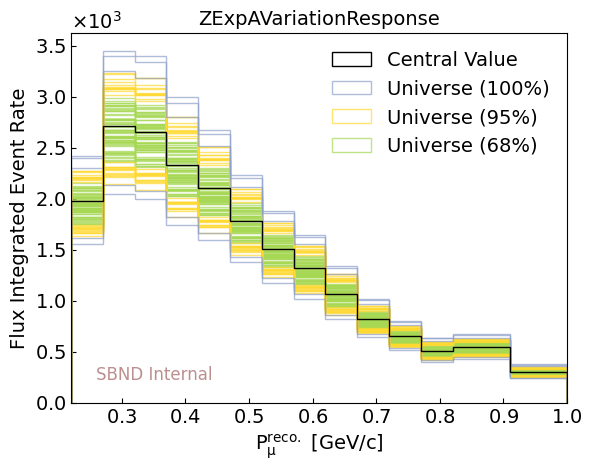

generating covariance for xsec, using scale factor: 3.6192046135874454e-43


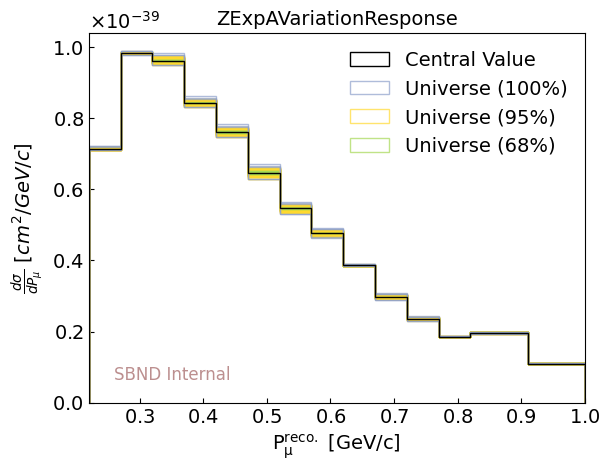

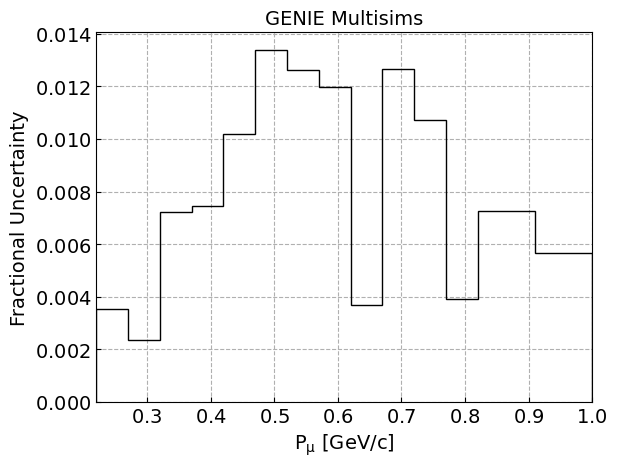

GENIEReWeight_SBN_v1_multisim_NCELVariationResponse
generating covariance for event rate


/tmp/ipykernel_175951/3445612672.py:170: RuntimeWarning: invalid value encountered in scalar divide
  Correlation[i, j] = Covariance[i, j] / (np.sqrt(Covariance[i, i]) * np.sqrt(Covariance[j, j]))


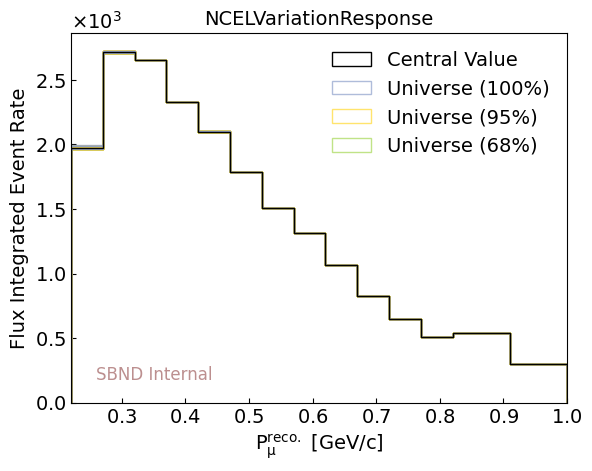

generating covariance for xsec, using scale factor: 3.6192046135874454e-43


/tmp/ipykernel_175951/3445612672.py:170: RuntimeWarning: invalid value encountered in scalar divide
  Correlation[i, j] = Covariance[i, j] / (np.sqrt(Covariance[i, i]) * np.sqrt(Covariance[j, j]))


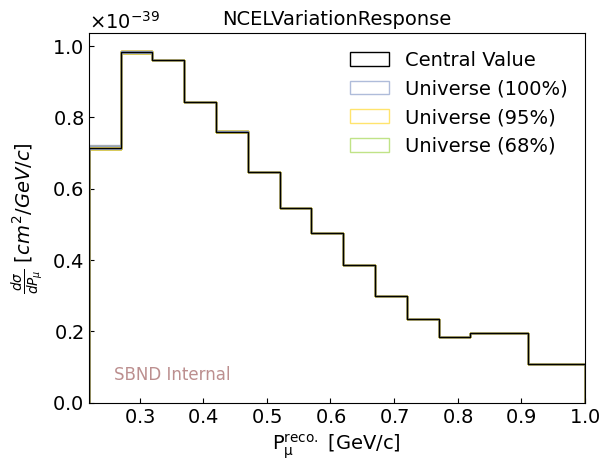

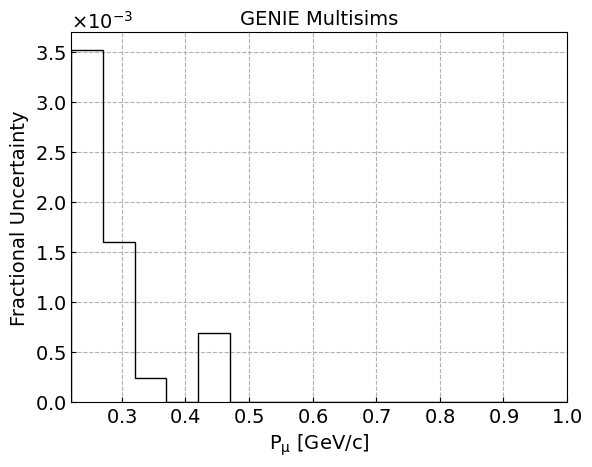

GENIEReWeight_SBN_v1_multisim_RPA_CCQE
generating covariance for event rate


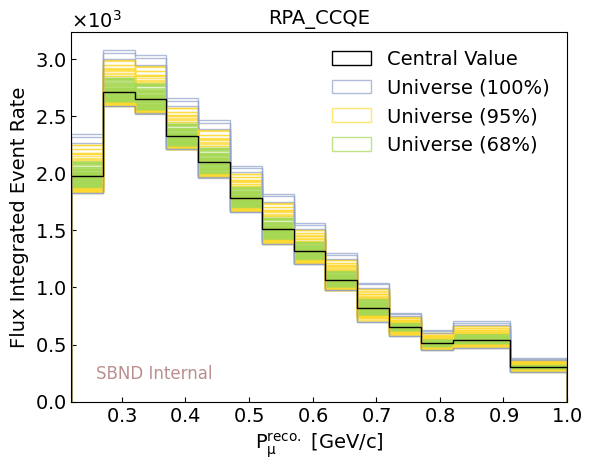

generating covariance for xsec, using scale factor: 3.6192046135874454e-43


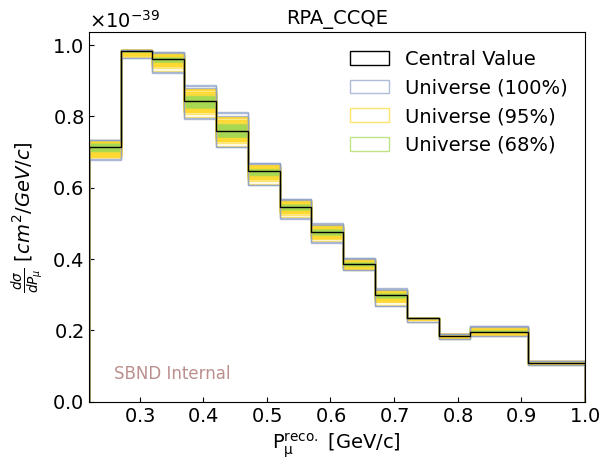

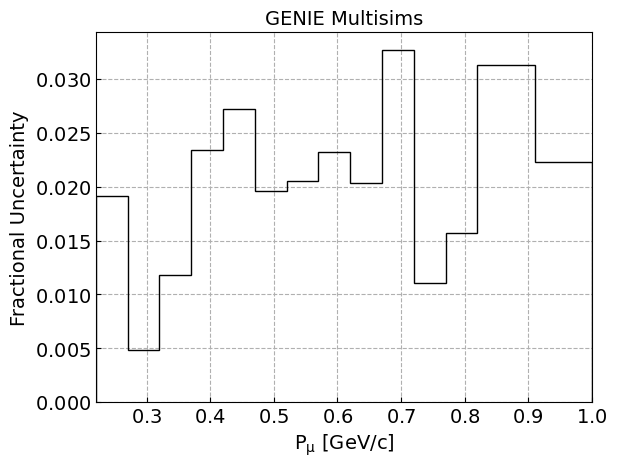

In [74]:
# multisim
n_univ_genie = 100
for sidx, syst_name in enumerate(regen_systematics_sbnd_multisim[:3]):
    title_name = syst_name.replace("GENIEReWeight_SBN_v1_multisim_", "")
    print(syst_name)

    cov_type = "event"
    plot_labels = [var_config.var_labels[1], "Flux Integrated Event Rate", title_name]
    save_fig_name = "{}/{}-{}-genie_univ_{}_rates".format(save_fig_dir, var_config.var_save_name, syst_name, cov_type)
    ret_genie_evt = get_covariance(cov_type, syst_name, n_univ_genie, 
                            nevts_signal_sel_reco, var_signal_sel_truth, var_signal_sel_reco, var_config.bins, 
                            plot_labels, save_fig=save_fig, save_fig_name=save_fig_name)

    cov_type = "xsec"
    plot_labels = [var_config.var_labels[1], var_config.xsec_label, title_name]
    save_fig_name = "{}/{}-{}-genie_univ_{}_rates".format(save_fig_dir, var_config.var_save_name, syst_name, cov_type)
    ret_genie = get_covariance(cov_type, syst_name, n_univ_genie, 
                            nevts_signal_sel_reco, var_signal_sel_truth, var_signal_sel_reco, var_config.bins, 
                            plot_labels, save_fig=save_fig, save_fig_name=save_fig_name)


    frac_cov = ret_genie["Covariance_Frac"]
    frac_unc = np.sqrt(np.diag(frac_cov))
    plt.hist(var_config.bin_centers, bins=var_config.bins, weights=frac_unc, histtype="step", color="black")
    plt.xlim(var_config.bins[0], var_config.bins[-1])
    plt.xlabel(var_config.var_labels[0])
    plt.ylabel("Fractional Uncertainty")
    plt.grid(True)
    plt.title("GENIE Multisims")
    plt.show();

    var_name = "_".join([v for v in var_config.var_nu_col if len(v) > 0])

    # frac_cov_matrices[var_name]["genie_multisim"+syst_name] = ret_genie["Covariance_Frac"]

In [58]:
# syst_name = "GENIE"
# save_fig_name = "{}/{}-{}-evt-covariance".format(save_fig_dir, var_config.var_save_name, syst_name)
# plot_heatmap(ret_genie_evt["Covariance"], "{} Covariance".format(syst_name),
#              save_fig=save_fig, save_fig_name=save_fig_name)
# save_fig_name = "{}/{}-{}-evt-covariance_frac".format(save_fig_dir, var_config.var_save_name, syst_name)
# plot_heatmap(ret_genie_evt["Covariance_Frac"], "{} Fractional Covariance".format(syst_name),
#              save_fig=save_fig, save_fig_name=save_fig_name)
# save_fig_name = "{}/{}-{}-evt-correlation".format(save_fig_dir, var_config.var_save_name, syst_name)
# plot_heatmap(ret_genie_evt["Correlation"], "{} Correlation".format(syst_name),
#              save_fig=save_fig, save_fig_name=save_fig_name)

# save_fig_name = "{}/{}-{}-covariance".format(save_fig_dir, var_config.var_save_name, syst_name)
# plot_heatmap(ret_genie["Covariance"], "{} Covariance".format(syst_name),
#              save_fig=save_fig, save_fig_name=save_fig_name)
# save_fig_name = "{}/{}-{}-covariance_frac".format(save_fig_dir, var_config.var_save_name, syst_name)
# plot_heatmap(ret_genie["Covariance_Frac"], "{} Fractional Covariance".format(syst_name),
#              save_fig=save_fig, save_fig_name=save_fig_name)
# save_fig_name = "{}/{}-{}-correlation".format(save_fig_dir, var_config.var_save_name, syst_name)
# plot_heatmap(ret_genie["Correlation"], "{} Correlation".format(syst_name),
#              save_fig=save_fig, save_fig_name=save_fig_name)

GENIE
generating covariance for event rate


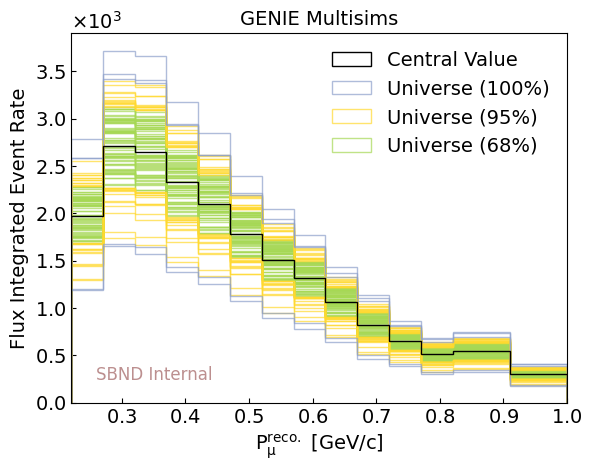

generating covariance for xsec, using scale factor: 3.6192046135874454e-43


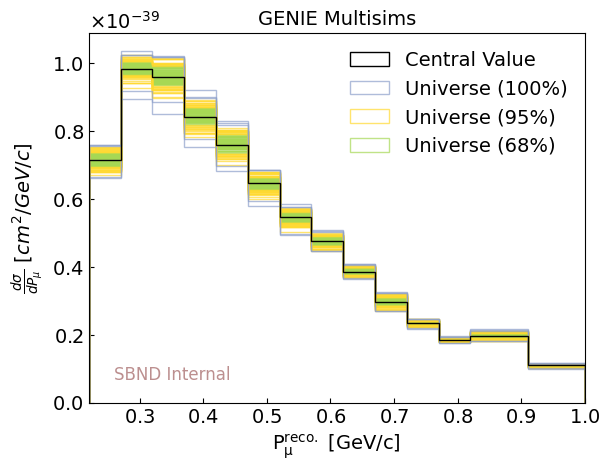

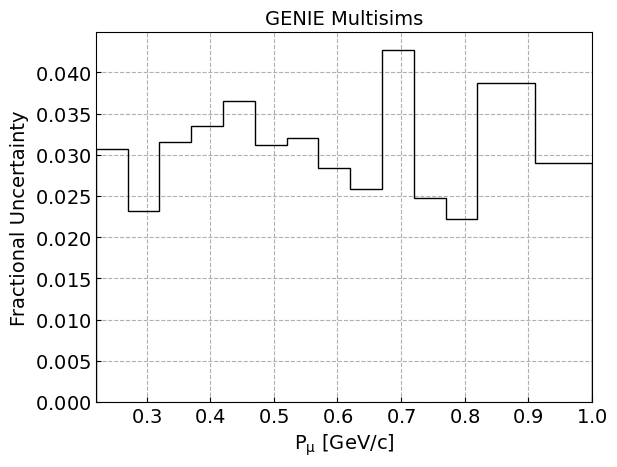

In [66]:
n_univ_genie = 100
syst_name = "GENIE"
print(syst_name)

cov_type = "event"
plot_labels = [var_config.var_labels[1], "Flux Integrated Event Rate", "GENIE Multisims"]
save_fig_name = "{}/{}-{}-genie_univ_{}_rates".format(save_fig_dir, var_config.var_save_name, syst_name, cov_type)
ret_genie_evt = get_covariance(cov_type, syst_name, n_univ_genie, 
                          nevts_signal_sel_reco, var_signal_sel_truth, var_signal_sel_reco, var_config.bins, 
                          plot_labels, save_fig=save_fig, save_fig_name=save_fig_name)

cov_type = "xsec"
plot_labels = [var_config.var_labels[1], var_config.xsec_label, "GENIE Multisims"]
save_fig_name = "{}/{}-{}-genie_univ_{}_rates".format(save_fig_dir, var_config.var_save_name, syst_name, cov_type)
ret_genie = get_covariance(cov_type, syst_name, n_univ_genie, 
                          nevts_signal_sel_reco, var_signal_sel_truth, var_signal_sel_reco, var_config.bins, 
                          plot_labels, save_fig=save_fig, save_fig_name=save_fig_name)


frac_cov = ret_genie["Covariance_Frac"]
frac_unc = np.sqrt(np.diag(frac_cov))
plt.hist(var_config.bin_centers, bins=var_config.bins, weights=frac_unc, histtype="step", color="black")
plt.xlim(var_config.bins[0], var_config.bins[-1])
plt.xlabel(var_config.var_labels[0])
plt.ylabel("Fractional Uncertainty")
plt.grid(True)
plt.title("GENIE Multisims")
plt.show();

var_name = "_".join([v for v in var_config.var_nu_col if len(v) > 0])

frac_cov_matrices[var_name]["genie_multisim"] = ret_genie["Covariance_Frac"]

In [68]:
frac_cov_matrices['mu_totp'].keys()

dict_keys(['genie_multisimGENIEReWeight_SBN_v1_multisim_ZExpAVariationResponse', 'genie_multisimGENIEReWeight_SBN_v1_multisim_NCELVariationResponse', 'genie_multisimGENIEReWeight_SBN_v1_multisim_RPA_CCQE', 'genie_multisim'])

# Save cov matrices

In [ ]:
# frac_cov_matrices = {}

In [ ]:
# var_name = "_".join([v for v in var_config.var_nu_col if len(v) > 0])

# frac_cov_matrices[var_name] = {
#     "genie_multisim": ret_genie["Covariance_Frac"]
# }

In [ ]:
# save the frac cov matrices to a hdf5 file
import pickle

# with open("/exp/sbnd/data/users/munjung/xsec/2025B/frac_cov_matrices_multisim.pkl", "wb") as f:
    # pickle.dump(frac_cov_matrices, f)

# Demo plots for technote

## Event rate variations for each source

In [ ]:
# makes weights for nu events only (i.e. cosmics won't have genie weights)
syst_knob_list = regen_systematics_sbnd_morph
for this_syst in tqdm(syst_knob_list):
    has_genie_weights = (mc_evt_df[this_syst].morph.notna())
    weights_morph = mc_evt_df[has_genie_weights][this_syst].morph

    var = mc_evt_df[has_genie_weights][var_config.var_evt_reco_col]
    var = np.clip(var, var_config.bins[0], var_config.bins[-1] - eps)

    weights_std = (weights_morph-1)
    rand_wgt = np.random.normal(loc=0, scale=1, size=(100))
    n_univ_list = []
    binned_n_univ_list = []
    for i in range(100):
        weights_rand = 1 + np.abs(rand_wgt[i]) * weights_std
        n_univ, _ = np.histogram(var, bins=var_config.bins, weights=weights_rand)
        n_univ_list.append(n_univ)

        n_univ_binned, _, _ = plt.hist(var_config.bin_centers, bins=var_config.bins, weights=n_univ, histtype="step", color="gray", alpha=0.5)
        binned_n_univ_list.append(n_univ_binned)

    alternate_cv_morph, _, _ = plt.hist(var, bins=var_config.bins, weights=weights_morph, histtype="step", color="steelblue")

    std_binned = np.std(binned_n_univ_list, axis=0)
    mean_binned = np.mean(binned_n_univ_list, axis=0)
    plt.errorbar(var_config.bin_centers, mean_binned, yerr=std_binned, fmt="o", color="red")

    plt.title(this_syst)
    plt.show()

## GENIE variations for each mode
- demonstrates why the GENIE uncertainty for this channel is small, by comparing the signal vs. background scale

In [ ]:
syst_name = "GENIE"
for midx,this_mc_evt_df in enumerate(mc_evt_df_divided):
    print(topology_list[midx])
    for uidx in range(99):
        univ_col_evt = (syst_name, "univ_{}".format(uidx), "", "", "", "", "", "")
        univ_col_mc = (syst_name, "univ_{}".format(uidx), "")
        weights = this_mc_evt_df[univ_col_evt].copy()
        weights[np.isnan(weights)] = 1 ## IMPORTANT: make nan weights to 1. to ignore them
        this_var = this_mc_evt_df[var_config.var_evt_reco_col]
        this_var = np.clip(this_var, var_config.bins[0], var_config.bins[-1] - eps)
        # background_univ, _ = np.histogram(this_var, bins=var_config.bins, weights=weights)
        if uidx == 0:
            background_univ, _, _ = plt.hist(this_var, bins=var_config.bins, weights=weights, histtype="step", color=topology_colors[midx], alpha=0.5, label="UV")
        else:
            background_univ, _, _ = plt.hist(this_var, bins=var_config.bins, weights=weights, histtype="step", color=topology_colors[midx], alpha=0.5)
        background_univ = np.array(background_univ)
    # background_cv, _ = np.histogram(this_var, bins=var_config.bins)
    background_cv, _, _ = plt.hist(this_var, bins=var_config.bins, histtype="step", color="black", label="CV")
    background_cv = np.array(background_cv)
    plt.title(topology_labels[midx])
    plt.show();

## Variations on eff, smearing

In [ ]:
# change response matrix to get just the smearing, for demo plots
def get_response_matrix_noeff(reco_vs_true, eff, bins, 
                     plot=True, var_labels=None,
                     save_fig=False, save_fig_name=None):
    denom = reco_vs_true.T.sum(axis=0)
    num = reco_vs_true.T
    Response = np.divide(
        # num * eff, denom,
        num, denom,
        out=np.zeros_like(num, dtype=float),  # fill with 0 where invalid
        where=denom != 0
    )

    if plot:
        fig, ax = plt.subplots(figsize=(10, 10))
        unif_bin = np.linspace(0., float(len(bins) - 1), len(bins))
        extent = [unif_bin[0], unif_bin[-1], unif_bin[0], unif_bin[-1]]
        plt.imshow(Response, extent=extent, origin="lower", cmap="viridis")
        plt.colorbar(label="Response", shrink=0.7)

        x_edges = np.array(bins)
        y_edges = np.array(bins)
        x_tick_positions = (unif_bin[:-1] + unif_bin[1:]) / 2
        y_tick_positions = (unif_bin[:-1] + unif_bin[1:]) / 2

        x_labels = bin_range_labels(x_edges)
        y_labels = bin_range_labels(y_edges)

        plt.xticks(x_tick_positions, x_labels, rotation=45, ha="right")
        plt.yticks(y_tick_positions, y_labels)

        if var_labels is not None:
            plt.xlabel(var_labels[2], fontsize=20)
            plt.ylabel(var_labels[1], fontsize=20)

        for i in range(Response.shape[0]):      # rows (y)
            for j in range(Response.shape[1]):  # columns (x)
                value = Response[i, j]
                if not np.isnan(value):  # skip NaNs
                    plt.text(
                        j + 0.5, i + 0.5,
                        f"{value:.3f}",
                        ha="center", va="center",
                        color=get_text_color(value),
                        fontsize=10
                    )

        plt.title("Response", fontsize=20)
        plt.tight_layout()

        if save_fig and save_fig_name is not None:
            plt.savefig("{}.pdf".format(save_fig_name), bbox_inches="tight")
        plt.show()
    return Response

In [ ]:
from analysis_village.unfolding.unfolding_inputs import get_text_color, bin_range_labels

true_signal_univ, _ = np.histogram(var_truth_signal, bins=var_config.bins)
smear_cv = get_smear_matrix(var_signal_sel_truth, var_signal_sel_reco, var_config.bins, plot=False)
eff_cv = get_eff(smear_cv, true_signal_univ) 

eff_vars = ret_genie["univ_effs"]
for i in range(len(eff_vars)):
    if i == 0:
        plt.hist(var_config.bin_centers, bins=var_config.bins, weights=eff_vars[i], histtype="step", color="steelblue", alpha=0.5,
        label="UV")
    else:
        plt.hist(var_config.bin_centers, bins=var_config.bins, weights=eff_vars[i], histtype="step", color="steelblue", alpha=0.5)
plt.hist(var_config.bin_centers, bins=var_config.bins, weights=eff_cv, histtype="step", color="black", label="CV")
plt.xlim(var_config.bins[0], var_config.bins[-1])
plt.xlabel(var_config.var_labels[0])
plt.ylabel("Efficiency")
plt.title("GENIE Systematics")
plt.legend()
if save_fig:
    plt.savefig(path.join(save_fig_dir, "{}-{}-genie-effs".format(var_config.var_save_name, syst_name)))
plt.show();


smear_vars = ret_genie["univ_smears"]
smear_std = np.std(smear_vars, axis=0)
smear_mean = np.mean(smear_vars, axis=0)

# diagonal elements
for i in range(len(smear_vars)):
    this_diag = np.diag(smear_vars[i])
    plt.hist(var_config.bin_centers, bins=var_config.bins, weights=this_diag, histtype="step", color="steelblue", alpha=0.5)
cv_diag = np.diag(smear_cv)
plt.hist(var_config.bin_centers, bins=var_config.bins, weights=cv_diag, histtype="step", color="black")
plt.xlim(var_config.bins[0], var_config.bins[-1])
plt.xlabel(var_config.var_labels[0])
plt.ylabel("Diagonal Elements of Smearing Matrix")
plt.title("GENIE Systematics")
plt.show();

# full matrix
fig, ax = plt.subplots(figsize=(10, 10))
unif_bin = np.linspace(0., float(len(var_config.bins) - 1), len(var_config.bins))
extent = [unif_bin[0], unif_bin[-1], unif_bin[0], unif_bin[-1]]

plt.imshow(smear_std/smear_cv, extent=extent, origin="lower", cmap="viridis")
plt.colorbar(label="Univ Std / Univ Mean", shrink=0.7)

x_edges = np.array(var_config.bins)
y_edges = np.array(var_config.bins)
x_tick_positions = (unif_bin[:-1] + unif_bin[1:]) / 2
y_tick_positions = (unif_bin[:-1] + unif_bin[1:]) / 2

x_labels = bin_range_labels(x_edges)
y_labels = bin_range_labels(y_edges)

plt.xticks(x_tick_positions, x_labels, rotation=45, ha="right")
plt.yticks(y_tick_positions, y_labels)

for i in range(smear_std.shape[0]):      # rows (y)
    for j in range(smear_std.shape[1]):  # columns (x)
        value = smear_std[i, j] / smear_cv[i, j]
        if not np.isnan(value):  # skip NaNs
            plt.text(
                j + 0.5, i + 0.5,
                f"{value:.2f}",
                ha="center", va="center",
                color=get_text_color(value),
                fontsize=10
            )

plt.xlabel(var_config.var_labels[2])
plt.ylabel(var_config.var_labels[1])
plt.title("GENIE Systematics")
plt.show();

# smeared event rates
for i in range(len(smear_vars)):
    # this_events = smear_vars[i] @ nevts_signal_truth
    this_response = get_response_matrix_noeff(smear_vars[i], eff_vars[i], var_config.bins, plot=False)
    this_events = this_response @ nevts_signal_sel_truth
    if i == 0:
        plt.hist(var_config.bin_centers, bins=var_config.bins, weights=this_events, histtype="step", color="steelblue", alpha=0.5,
        label="UV")
    else:
        plt.hist(var_config.bin_centers, bins=var_config.bins, weights=this_events, histtype="step", color="steelblue", alpha=0.5)
# cv_events = smear_cv @ nevts_signal_sel_truth # note that we multiply the CV signal rate!
cv_response = get_response_matrix_noeff(smear_cv, eff_cv, var_config.bins, plot=False)
cv_events = cv_response @ nevts_signal_sel_truth
plt.hist(var_config.bin_centers, bins=var_config.bins, weights=cv_events, histtype="step", color="black", label="CV")
plt.xlim(var_config.bins[0], var_config.bins[-1])
plt.xlabel(var_config.var_labels[0])
plt.ylabel("Selected Event Rates")
plt.title("GENIE Systematics")
plt.legend()
if save_fig:
    plt.savefig(path.join(save_fig_dir, "{}-{}-genie-smeared_events".format(var_config.var_save_name, syst_name)))
plt.show();